# Probabilistic Roadmap


In this notebook you'll expand on previous random sampling exercises by creating a graph from the points and running A*.

1. Load the obstacle map data
2. Sample nodes (use KDTrees here)
3. Connect nodes (use KDTrees here)
4. Visualize graph
5. Define heuristic
6. Define search method
7. Execute and visualize

We'll load the data for you and provide a template for visualization.

In [1]:
# Again, ugly but we need the latest version of networkx!
# This sometimes fails for unknown reasons, please just 
# "reset and clear output" from the "Kernel" menu above 
# and try again!
import sys
!{sys.executable} -m pip install -I networkx==2.1
import pkg_resources
pkg_resources.require("networkx==2.1")
import networkx as nx

    100% |████████████████████████████████| 1.6MB 408kB/s eta 0:00:01   17% |█████▊                          | 286kB 5.8MB/s eta 0:00:01    38% |████████████▏                   | 614kB 7.9MB/s eta 0:00:01    97% |███████████████████████████████▎| 1.6MB 13.3MB/s eta 0:00:01
  Running setup.py bdist_wheel for networkx ... done
  Stored in directory: /root/.cache/pip/wheels/a0/33/4e/7c9228ea77f8090e895d8d2b76f3b5a76997a5b3edeb4e2c6f
Successfully built networkx
You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


VersionConflict: (networkx 1.11 (/opt/conda/lib/python3.6/site-packages), Requirement.parse('networkx==2.1'))

In [3]:
import networkx as nx
nx.__version__ # should be 2.1

'2.1'

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, LineString
from queue import PriorityQueue
from sampling import Sampler
%matplotlib inline

In [5]:
plt.rcParams['figure.figsize'] = 14, 14

## Step 1 - Load Data

In [15]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ..., 
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


## Step 2 - Sample Points


You may want to limit the z-axis values.

In [44]:
# TODO: sample points randomly
# then use KDTree to find nearest neighbor polygon
# and test for collision

def extract_polygons(data):

    polygons = []
    for i in range(data.shape[0]):
        north, east, alt, d_north, d_east, d_alt = data[i, :]
        
        min_north = north - d_north
        min_east = east - d_east
        max_east = east + d_east
        max_north = north + d_north
        
        height = alt
        br = (max_north, max_east)
        bl = (max_north, min_east)
        tl = (min_north, min_east)
        tr = (min_north, max_east)
        
        # TODO: Extract the 4 corners of the obstacle
        # 
        # NOTE: The order of the points matters since
        # `shapely` draws the sequentially from point to point.
        #
        # If the area of the polygon is 0 you've likely got a weird
        # order.
        corners = [tl, tr, br, bl]
        
        # TODO: Compute the height of the polygon
        height = d_alt + alt

        # TODO: Once you've defined corners, define polygons
        p = Polygon(corners)
        polygons.append((p, height))
    centroids = [(p.centroid.x, p.centroid.y) for p, _ in polygons]
    return polygons, centroids


In [45]:
polygons, centroids = extract_polygons(data)

In [72]:
xmin = np.min(data[:, 0] - data[:, 3])
xmax = np.max(data[:, 0] + data[:, 3])

ymin = np.min(data[:, 1] - data[:, 4])
ymax = np.max(data[:, 1] + data[:, 4])

zmin = 0
# Limit the z axis for the visualization
zmax = 20

print("X")
print("min = {0}, max = {1}\n".format(xmin, xmax))

print("Y")
print("min = {0}, max = {1}\n".format(ymin, ymax))

print("Z")
print("min = {0}, max = {1}".format(zmin, zmax))

num_samples = 500

xvals = np.random.uniform(xmin, xmax, num_samples)
yvals = np.random.uniform(ymin, ymax, num_samples)
zvals = np.random.uniform(zmin, zmax, num_samples)

samples = list(zip(xvals, yvals, zvals))

X
min = -315.2389, max = 604.7611

Y
min = -444.2315, max = 475.7685

Z
min = 0, max = 20


In [65]:
np.array(centroids).shape

(3845, 2)

In [73]:
good_points = []
tree = KDTree(np.array(centroids))
idxs = tree.query(np.array(samples)[:,:2], k=3, return_distance = False)
for j, idx in enumerate(idxs):
    polys = [polygons[i] for i in idx]
    contains = [p.contains(Point(samples[j])) and h >= samples[j][2] for p, h in polys]
    if not True in contains:
        good_points += [samples[j]]

In [67]:
len(good_points)

187

## Step 3 - Connect Nodes

Now we have to connect the nodes. There are many ways they might be done, it's completely up to you. The only restriction being no edge connecting two nodes may pass through an obstacle.

NOTE: You can use `LineString()` from the `shapely` library to create a line. Additionally, `shapely` geometry objects have a method `.crosses` which return `True` if the geometries cross paths, for instance your `LineString()` with an obstacle `Polygon()`!

In [41]:
# TODO: connect nodes
# Suggested method
    # 1) cast nodes into a graph called "g" using networkx
    # 2) write a method "can_connect()" that:
        # casts two points as a shapely LineString() object
        # tests for collision with a shapely Polygon() object
        # returns True if connection is possible, False otherwise
    # 3) write a method "create_graph()" that:
        # defines a networkx graph as g = Graph()
        # defines a tree = KDTree(nodes)
        # test for connectivity between each node and 
            # k of it's nearest neighbors
        # if nodes are connectable, add an edge to graph
    # Iterate through all candidate nodes!
import numpy.linalg as LA
from sklearn.neighbors import KDTree    

In [68]:
def can_connect(n1, n2):
    l = LineString([n1, n2])
    for p, height in polygons:
        if p.crosses(l) and height >= min(n1[2], n2[2]):
            return False
    return True

def create_graph(nodes, k):
    g = nx.Graph()
    tree = KDTree(nodes)
    for n1 in nodes:
        # for each node connect try to connect to k nearest nodes
        idxs = tree.query([n1], k, return_distance=False)[0]
        
        for idx in idxs:
            n2 = nodes[idx]
            if n2 == n1:
                continue
                
            if can_connect(n1, n2):
                g.add_edge(n1, n2, weight=1)
    return g

In [74]:
nodes = good_points
g = create_graph(nodes, 10)

## Step 4 - Visualize Graph

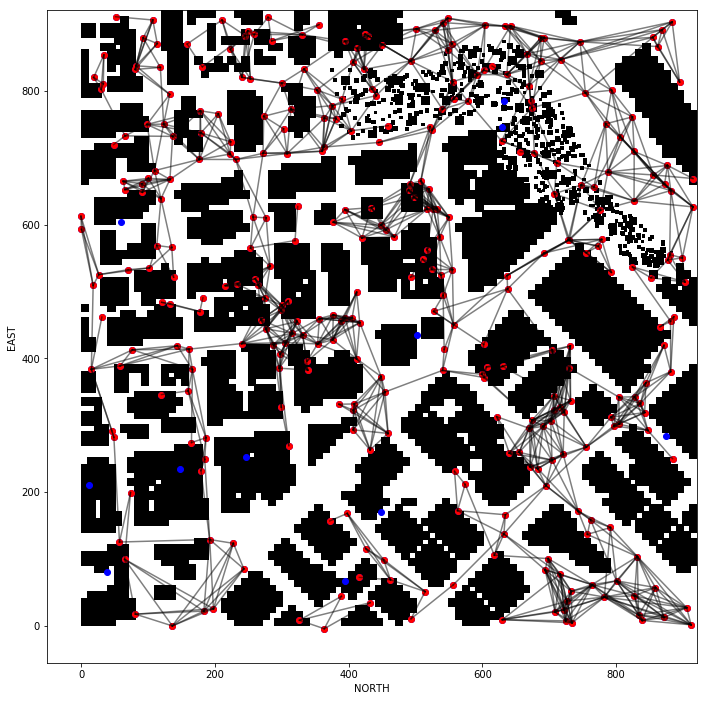

In [75]:
plt.rcParams['figure.figsize'] = 12, 12
# Create a grid map of the world
from grid import create_grid
# This will create a grid map at 1 m above ground level
grid = create_grid(data, 1, 1)

fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')

nmin = np.min(data[:, 0])
emin = np.min(data[:, 1])

# If you have a graph called "g" these plots should work
# Draw edges
for (n1, n2) in g.edges:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'black' , alpha=0.5)

# Draw all nodes connected or not in blue
for n1 in nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='blue')
    
# Draw connected nodes in red
for n1 in g.nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='red')
    


plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()

## Step 5 - Define Heuristic

In [60]:
def heuristic(n1, n2):
     return LA.norm(np.array(n2) - np.array(n1))

## Step 6 - Complete A*

In [61]:
def a_star(graph, heuristic, start, goal):
    """Modified A* to work with NetworkX graphs."""
    
    # TODO: complete

    path = []
    queue = PriorityQueue()
    queue.put((0, start))
    visited = set(start)

    branch = {}
    found = False
    
    while not queue.empty():
        item = queue.get()
        current_cost = item[0]
        current_node = item[1]

        if current_node == goal:        
            print('Found a path.')
            found = True
            break
        else:
            for next_node in graph[current_node]:
                cost = graph.edges[current_node, next_node]['weight']
                new_cost = current_cost + cost + heuristic(next_node, goal)
                
                if next_node not in visited:                
                    visited.add(next_node)               
                    queue.put((new_cost, next_node))
                    
                    branch[next_node] = (new_cost, current_node)
             
    path = []
    path_cost = 0
    if found:
        
        # retrace steps
        path = []
        n = goal
        path_cost = branch[n][0]
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(branch[n][1])
            
    return path[::-1], path_cost

In [76]:
start = list(g.nodes)[0]
k = np.random.randint(len(g.nodes))
print(k, len(g.nodes))
goal = list(g.nodes)[k]

202 339


In [77]:
path, cost = a_star(g, heuristic, start, goal)
print(len(path), path)

Found a path.
10 [(409.58258935070745, -390.7092098134255, 7.5847150891278181), (422.73721766877162, -373.55852234070795, 15.672850475317668), (421.93264627112814, -302.44370417286575, 8.3324842996395887), (387.51399478067827, -262.49479773518141, 16.018727774061816), (387.40821781315714, -208.12949269209307, 2.5132889062758479), (300.04103955288002, -162.46393244567128, 0.27672502345949646), (227.81862799051163, -156.67377141939659, 8.259009088480127), (180.06006339149445, -164.36687822088038, 18.779297942050498), (169.21861919801086, -138.85853599072829, 15.760707374006), (125.0508898033018, -107.99585670008594, 14.569309897860363)]


In [78]:
path_pairs = zip(path[:-1], path[1:])
for (n1, n2) in path_pairs:
    print(n1, n2)

(409.58258935070745, -390.7092098134255, 7.5847150891278181) (422.73721766877162, -373.55852234070795, 15.672850475317668)
(422.73721766877162, -373.55852234070795, 15.672850475317668) (421.93264627112814, -302.44370417286575, 8.3324842996395887)
(421.93264627112814, -302.44370417286575, 8.3324842996395887) (387.51399478067827, -262.49479773518141, 16.018727774061816)
(387.51399478067827, -262.49479773518141, 16.018727774061816) (387.40821781315714, -208.12949269209307, 2.5132889062758479)
(387.40821781315714, -208.12949269209307, 2.5132889062758479) (300.04103955288002, -162.46393244567128, 0.27672502345949646)
(300.04103955288002, -162.46393244567128, 0.27672502345949646) (227.81862799051163, -156.67377141939659, 8.259009088480127)
(227.81862799051163, -156.67377141939659, 8.259009088480127) (180.06006339149445, -164.36687822088038, 18.779297942050498)
(180.06006339149445, -164.36687822088038, 18.779297942050498) (169.21861919801086, -138.85853599072829, 15.760707374006)
(169.2186191

## Step 7 - Visualize Path

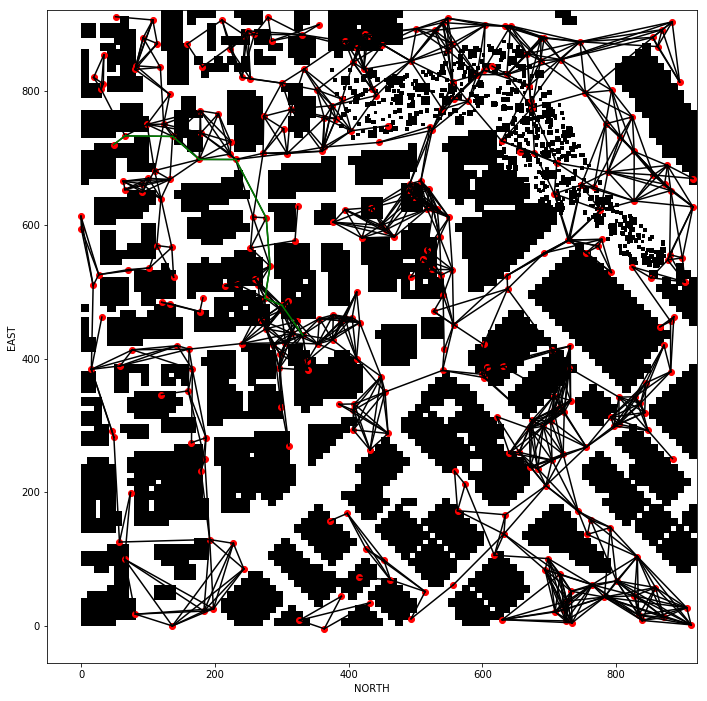

In [83]:
fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')

# Add code to visualize path here
nmin = np.min(data[:, 0])
emin = np.min(data[:, 1])

# draw nodes
for n1 in g.nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='red')
    
# draw edges
for (n1, n2) in g.edges:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'black')
    
# TODO: add code to visualize the path
path_pairs = zip(path[:-1], path[1:])
for (n1, n2) in path_pairs:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'green')

plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()

[solution](/notebooks/Probabilistic-Roadmap-Solution.ipynb)